<h3>Patient Triage and Diagnosis System</h3>

<a href="https://sivasaigajula.medium.com/automating-patient-triage-and-diagnosis-with-generative-ai-378b9db2d0cf" target="_blank">
  <button style="
    background-color: #c2fbd7;
    border-radius: 100px;
    box-shadow: rgba(44, 187, 99, .2) 0 -25px 18px -14px inset,
                rgba(44, 187, 99, .15) 0 1px 2px,
                rgba(44, 187, 99, .15) 0 2px 4px,
                rgba(44, 187, 99, .15) 0 4px 8px,
                rgba(44, 187, 99, .15) 0 8px 16px,
                rgba(44, 187, 99, .15) 0 16px 32px;
    color: green;
    cursor: pointer;
    display: inline-block;
    font-family: CerebriSans-Regular,-apple-system,system-ui,Roboto,sans-serif;
    padding: 7px 20px;
    text-align: center;
    text-decoration: none;
    transition: all 250ms;
    border: 0;
    font-size: 16px;
    user-select: none;
    -webkit-user-select: none;
    touch-action: manipulation;
  ">
    Medium Article
  </button>
</a>


## Description
**Patient Triage and Diagnosis System** to assist healthcare professionals. The system processes patient symptoms, vitals, and medical history to:
- **Triage Patients**: Assigns a triage priority (Emergent, Urgent, Non-urgent) based on a scoring algorithm.
- **Predict Cardiovascular Risk**: Estimates long-term cardiovascular risk using age, vitals, and history.
- **Diagnose Conditions**: Generates structured diagnoses with confidence scores and recommended actions, grounded in real-time medical knowledge from the internet.
- **Analyze Symptom Similarity**: Compares patient symptoms to known symptom sets, visualized in a styled chart.
- **Track Patient History**: Maintains an Electronic Health Record (EHR) store.
- **Support Multi-Language Output**: Provides results in languages like Spanish.
- **Present Results**: Outputs a professional HTML/CSS-formatted report with a styled chart.

The system uses generative AI to fetch medical knowledge dynamically, ensuring up-to-date diagnoses. It is suitable for clinical, research, or educational use.

## GenAI Models Used
1. **Gemini-2.0-Flash (google.genai)**:
   - Handles function calling, structured JSON output, diagnosis generation, and translation.
   - Chosen for its speed and versatility in text-based tasks.
2. **Text-Embedding-004 (google.genai)**:
   - Generates embeddings for medical documents, patient queries, and symptom similarity analysis.
   - Optimized for semantic similarity and retrieval.
3. **Google Search Tool (google.genai)**:
   - Retrieves real-time medical knowledge from credible sources (`.edu`, `.gov`, `.org`).
   - Enables dynamic, internet-based Retrieval Augmented Generation (RAG).

## Flow Chart
<img src="https://raw.githubusercontent.com/sivasaigajula/automated-triage-diagnosis-genai/refs/heads/main/Images/FlowChart.png" alt="Flow Chart" width="500"/>

## Sequence Diagram
<img src="https://raw.githubusercontent.com/sivasaigajula/automated-triage-diagnosis-genai/refs/heads/main/Images/SequenceDiagram.png" alt="Sequence Diagram" />

## Class Diagram
<img src="https://raw.githubusercontent.com/sivasaigajula/automated-triage-diagnosis-genai/refs/heads/main/Images/ClassDiagram.png" alt="Class Diagram" width="500"/>



## Import Libraries and Setup Logging

This cell imports necessary Python libraries and configures logging for debugging and monitoring. Key libraries include:
- **google.genai**: For interacting with Gemini models and embeddings.
- **numpy, pandas**: For vector search and symptom similarity analysis.
- **matplotlib**: For generating the symptom similarity chart.
- **IPython.display**: For rendering HTML/CSS output in Jupyter.
- **logging**: For tracking API calls and errors.

Logging is set to `INFO` level to capture important events like API responses and fallbacks.

## Setup

Install the Python SDK.

In [1]:
!pip cache purge
!pip install -U -q "google-genai==1.7.0"

Files removed: 0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 5.3 MB/s eta 0:00:00


In [2]:
import google.genai as genai
import google.genai.types as types
from google.api_core import retry
import json
import numpy as np
import pandas as pd
from IPython.display import display, HTML, Markdown
import matplotlib.pyplot as plt
import io
import base64
from datetime import datetime
import uuid
import logging
import re

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

genai.__version__

'1.7.0'

### Set up your API key

To run the following cell, your API key must be stored it in a [Kaggle secret](https://www.kaggle.com/discussions/product-feedback/114053) named `GOOGLE_API_KEY`.

If you don't already have an API key, you can grab one from [AI Studio](https://aistudio.google.com/app/apikey). You can find [detailed instructions in the docs](https://ai.google.dev/gemini-api/docs/api-key).

To make the key available through Kaggle secrets, choose `Secrets` from the `Add-ons` menu and follow the instructions to add your key or enable it for this notebook.

In [3]:
from kaggle_secrets import UserSecretsClient
GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
client = genai.Client(api_key=GOOGLE_API_KEY)

## Configure Retry Policy

This cell sets up a retry policy for API calls to handle transient errors (e.g., rate limits, server issues). It defines a predicate (`is_retriable`) to retry on specific API errors (HTTP 429, 503) and applies it to the `generate_content` method of the Gemini model. This ensures robustness in API interactions.

In [4]:
# Configure retry policy
is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})
genai.models.Models.generate_content = retry.Retry(predicate=is_retriable)(genai.models.Models.generate_content)

## Define Triage and Risk Prediction Functions

This cell defines two mock functions used in function calling:
- **calculate_triage_score**: Computes a triage score based on symptoms (e.g., chest pain, shortness of breath), vitals (e.g., heart rate, blood pressure), and patient history (e.g., heart disease). Outputs a score and priority (Emergent, Urgent, Non-urgent).
- **predict_cardiovascular_risk**: Estimates cardiovascular risk based on age, blood pressure, and hypertension history. Outputs a risk score and level (High, Moderate, Low).

These functions are invoked by the Gemini model via function calling to support triage and risk assessment.

In [5]:
# Mock Electronic Health Record (EHR) store
ehr_store = {}

# Mock function to calculate triage score
def calculate_triage_score(symptoms: str, vitals: dict, patient_history: dict) -> dict:
    score = 0
    if "chest pain" in symptoms.lower():
        score += 50
    if "shortness of breath" in symptoms.lower():
        score += 30
    if vitals.get("heart_rate", 0) > 100:
        score += 20
    if vitals.get("blood_pressure", "").startswith("1") and int(vitals.get("blood_pressure", "0/0").split("/")[0]) > 140:
        score += 10
    if patient_history.get("previous_conditions", {}).get("heart_disease", False):
        score += 15
    priority = "Emergent" if score > 70 else "Urgent" if score > 30 else "Non-urgent"
    return {"triage_score": score, "priority": priority}

# Mock function to predict cardiovascular risk
def predict_cardiovascular_risk(age: int, vitals: dict, history: dict) -> dict:
    risk_score = 0
    if age > 40:
        risk_score += 20
    if vitals.get("blood_pressure", "").startswith("1") and int(vitals.get("blood_pressure", "0/0").split("/")[0]) > 140:
        risk_score += 15
    if history.get("previous_conditions", {}).get("hypertension", False):
        risk_score += 10
    risk_level = "High" if risk_score > 30 else "Moderate" if risk_score > 15 else "Low"
    return {"risk_score": risk_score, "risk_level": risk_level}

## Fetch Medical Knowledge from the Internet

This cell defines the `fetch_medical_knowledge` function, which retrieves real-time medical information from the internet using the Google Search tool. Key features:
- Queries credible sources (`.edu`, `.gov`, `.org`) based on patient symptoms.
- Filters results to include medical keywords (e.g., "diagnosis", "symptoms") and sufficient length.
- Limits content to 500 characters for efficiency.
- Falls back to mock data if the search fails.

This enables dynamic Retrieval Augmented Generation (RAG) with up-to-date medical knowledge.

In [6]:
# Function to retrieve medical information from the internet
def fetch_medical_knowledge(query: str, max_results: int = 5) -> list:
    try:
        # Configure Google Search tool
        search_config = types.GenerateContentConfig(
            tools=[types.Tool(google_search=types.GoogleSearch())]
        )
        search_query = f"medical information on {query} site:*.edu | site:*.gov | site:*.org"
        response = client.models.generate_content(
            model="gemini-2.0-flash",
            contents=search_query,
            config=search_config
        )
        
        # Extract search results
        documents = []
        for i, part in enumerate(response.candidates[0].content.parts):
            if hasattr(part, 'inline_data') and part.inline_data:
                content = part.inline_data.data
                # Clean and filter content
                content = re.sub(r'\s+', ' ', content).strip()
                if len(content) > 50 and any(keyword in content.lower() for keyword in ['diagnosis', 'symptoms', 'treatment']):
                    documents.append({
                        "id": i + 1,
                        "content": content[:500]  # Limit length for efficiency
                    })
        
        # Fallback mock data if no valid results
        if not documents:
            logger.warning("No valid search results, using fallback mock data")
            return [
                {"id": 1, "content": "Chest pain and shortness of breath may indicate myocardial infarction. Order ECG and troponin test."},
                {"id": 2, "content": "Pulmonary embolism presents with sudden dyspnea and chest pain. Consider CT pulmonary angiography."}
            ]
        
        return documents[:max_results]
    except Exception as e:
        logger.error(f"Error fetching medical knowledge: {str(e)}")
        # Fallback mock data
        return [
            {"id": 1, "content": "Chest pain and shortness of breath may indicate myocardial infarction. Order ECG and troponin test."},
            {"id": 2, "content": "Pulmonary embolism presents with sudden dyspnea and chest pain. Consider CT pulmonary angiography."}
        ]

## Vector Search and Embedding Functions

This cell defines functions for embedding and vector search, enabling RAG and symptom similarity analysis:
- **embed_documents**: Generates embeddings for medical documents or symptom texts using the `text-embedding-004` model.
- **vector_search**: Performs cosine similarity-based search to retrieve the top-k most relevant documents for a query.

These functions support the vector store and similarity analysis, leveraging embeddings for semantic matching.

In [7]:
# Generate embeddings for medical documents
def embed_documents(docs):
    response = client.models.embed_content(
        model="models/text-embedding-004",
        contents=[doc["content"] for doc in docs],
        config=types.EmbedContentConfig(task_type="retrieval_document")
    )
    return [{"id": doc["id"], "content": doc["content"], "embedding": emb.values} for doc, emb in zip(docs, response.embeddings)]

# Vector search function
def vector_search(query, docs_with_embeddings, top_k=3):
    query_response = client.models.embed_content(
        model="models/text-embedding-004",
        contents=[query],
        config=types.EmbedContentConfig(task_type="retrieval_query")
    )
    query_embedding = query_response.embeddings[0].values
    similarities = [
        np.dot(query_embedding, doc["embedding"]) / (np.linalg.norm(query_embedding) * np.linalg.norm(doc["embedding"]))
        for doc in docs_with_embeddings
    ]
    top_indices = np.argsort(similarities)[::-1][:top_k]
    return [docs_with_embeddings[i] for i in top_indices]

## Translation Function

This cell defines the `translate_text` function, which uses the Gemini model to translate the diagnosis output into a user-specified language (e.g., Spanish). This supports multi-language accessibility, making the system usable in diverse clinical settings.

In [8]:
# Translate text to target language
def translate_text(text: str, target_language: str) -> str:
    response = client.models.generate_content(
        model="gemini-2.0-flash",
        contents=f"Translate the following to {target_language}: {text}"
    )
    return response.candidates[0].content.parts[0].text

## Configure Function Calling

This cell defines the `function_config` for function calling, specifying two functions:
- **calculate_triage_score**: Schema for triage scoring based on symptoms, vitals, and history.
- **predict_cardiovascular_risk**: Schema for risk prediction based on age, vitals, and history.

The configuration is used by the Gemini model to dynamically invoke these functions during processing.

In [9]:
# Configure function calling
function_config = types.GenerateContentConfig(
    tools=[types.Tool(function_declarations=[
        types.FunctionDeclaration(
            name="calculate_triage_score",
            description="Calculate triage score based on symptoms, vitals, and patient history",
            parameters={
                "type": "object",
                "properties": {
                    "symptoms": {"type": "string"},
                    "vitals": {
                        "type": "object",
                        "properties": {
                            "heart_rate": {"type": "number"},
                            "blood_pressure": {"type": "string"}
                        }
                    },
                    "patient_history": {
                        "type": "object",
                        "properties": {
                            "previous_conditions": {
                                "type": "object",
                                "properties": {
                                    "heart_disease": {"type": "boolean"},
                                    "hypertension": {"type": "boolean"}
                                }
                            }
                        }
                    }
                }
            }
        ),
        types.FunctionDeclaration(
            name="predict_cardiovascular_risk",
            description="Predict cardiovascular risk based on age, vitals, and history",
            parameters={
                "type": "object",
                "properties": {
                    "age": {"type": "number"},
                    "vitals": {
                        "type": "object",
                        "properties": {
                            "blood_pressure": {"type": "string"}
                        }
                    },
                    "history": {
                        "type": "object",
                        "properties": {
                            "previous_conditions": {
                                "type": "object",
                                "properties": {
                                    "hypertension": {"type": "boolean"}
                                }
                            }
                        }
                    }
                }
            }
        )
    ])]
)

## Define Diagnosis Schema

This cell defines the `diagnosis_schema`, a JSON schema for structured output. It specifies fields like `patient_id`, `triage_priority`, `cardiovascular_risk`, `diagnoses`, `recommended_actions`, `retrieved_context`, and `timestamp`. This schema ensures consistent, machine-readable diagnosis outputs.

In [10]:
# Structured output schema
diagnosis_schema = {
    "type": "object",
    "properties": {
        "patient_id": {"type": "string"},
        "triage_priority": {"type": "string"},
        "cardiovascular_risk": {
            "type": "object",
            "properties": {
                "risk_score": {"type": "number"},
                "risk_level": {"type": "string"}
            }
        },
        "diagnoses": {
            "type": "array",
            "items": {
                "type": "object",
                "properties": {
                    "condition": {"type": "string"},
                    "confidence": {"type": "number"}
                }
            }
        },
        "recommended_actions": {"type": "array", "items": {"type": "string"}},
        "retrieved_context": {"type": "array", "items": {"type": "string"}},
        "timestamp": {"type": "string"}
    }
}

## Generate Symptom Similarity Chart

This cell defines the `visualize_symptom_similarity` function, which creates a styled Matplotlib chart comparing patient symptoms to known symptom sets. Key features:
- Uses green bars (`#4CAF50`) for consistency with the HTML theme.
- Includes grid lines and clear labels for readability.
- Outputs a base64-encoded PNG for embedding in the HTML report.

In [11]:
# Visualize symptom similarity
def visualize_symptom_similarity(sim_matrix, symptom_texts):
    plt.figure(figsize=(8, 6))
    plt.barh(symptom_texts, sim_matrix["chest pain, shortness of breath"], color='#4CAF50')
    plt.xlabel("Similarity Score", fontsize=12)
    plt.title("Symptom Similarity to 'Chest Pain, Shortness of Breath'", fontsize=14, pad=10)
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    buf = io.BytesIO()
    plt.savefig(buf, format="png")
    buf.seek(0)
    img_str = base64.b64encode(buf.read()).decode("utf-8")
    plt.close()
    return img_str

## Generate HTML Output

This cell defines the `generate_html_output` function, which creates a styled HTML report for the diagnosis, similarity analysis, chart, and EHR history. Key features:
- **Layout**: Card-based design with sections for each output component.
- **CSS**: Responsive design with a clean color scheme (blues and grays), shadows, and rounded corners.
- **Table**: Displays similarity scores with zebra striping and blue headers.
- **Chart**: Embeds the symptom similarity chart with a styled container (border, shadow, centered).


In [12]:
# Generate HTML output
def generate_html_output(diagnosis, sim_series, img_str, ehr_history):
    html_content = f"""
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Patient Triage and Diagnosis Report</title>
        <style>
            body {{
                font-family: 'Arial', sans-serif;
                line-height: 1.6;
                color: #333;
                max-width: 900px;
                margin: 0 auto;
                padding: 20px;
                background-color: #f4f4f4;
            }}
            h1 {{
                color: #2c3e50;
                text-align: center;
                margin-bottom: 30px;
            }}
            .card {{
                background: white;
                border-radius: 8px;
                box-shadow: 0 2px 4px rgba(0,0,0,0.1);
                padding: 20px;
                margin-bottom: 20px;
            }}
            h2 {{
                color: #34495e;
                border-bottom: 2px solid #3498db;
                padding-bottom: 5px;
                margin-bottom: 15px;
            }}
            pre {{
                background: #f8f8f8;
                padding: 15px;
                border-radius: 5px;
                overflow-x: auto;
                font-size: 14px;
            }}
            .chart-container {{
                text-align: center;
                margin: 20px 0;
            }}
            .chart-container img {{
                max-width: 100%;
                border: 2px solid #3498db;
                border-radius: 8px;
                box-shadow: 0 4px 8px rgba(0,0,0,0.1);
            }}
            table {{
                width: 100%;
                border-collapse: collapse;
                margin-top: 10px;
            }}
            th, td {{
                padding: 10px;
                text-align: left;
                border-bottom: 1px solid #ddd;
            }}
            th {{
                background-color: #3498db;
                color: white;
            }}
            tr:nth-child(even) {{
                background-color: #f2f2f2;
            }}
        </style>
    </head>
    <body>
        <h1>Patient Triage and Diagnosis Report</h1>
        
        <div class="card">
            <h2>Patient Triage and Diagnosis Result</h2>
            <pre>{json.dumps(diagnosis, indent=2)}</pre>
        </div>
        
        <div class="card">
            <h2>Symptom Similarity Analysis</h2>
            <table>
                <tr><th>Symptom</th><th>Similarity Score</th></tr>
                {''.join(f'<tr><td>{symptom}</td><td>{score:.4f}</td></tr>' for symptom, score in sim_series.items())}
            </table>
        </div>
        
        <div class="card">
            <h2>Symptom Similarity Visualization</h2>
            <div class="chart-container">
                <img src="data:image/png;base64,{img_str}" alt="Symptom Similarity Chart">
            </div>
        </div>
        
        <div class="card">
            <h2>Patient EHR History</h2>
            <pre>{json.dumps(ehr_history, indent=2)}</pre>
        </div>
    </body>
    </html>
    """
    return html_content

## Main Processing Function

This cell defines the `process_patient_data` function, the core of the system. It:
- Generates a unique patient ID if none is provided.
- Retrieves or initializes patient history from the EHR store.
- Fetches medical knowledge from the internet and performs vector search (RAG).
- Invokes triage and risk prediction via function calling, with fallback logic.
- Generates a structured diagnosis using the Gemini model and RAG context.
- Translates the output if requested (e.g., to Spanish).
- Computes symptom similarity and generates a chart.
- Produces an HTML/CSS-formatted report.

Returns both the JSON diagnosis and HTML output for display.

In [13]:
# Main patient processing function
def process_patient_data(patient_data: str, vitals: dict, age: int, patient_id: str = None, language: str = "English"):
    # Generate patient ID if not provided
    if not patient_id:
        patient_id = str(uuid.uuid4())
    
    # Retrieve or initialize patient history from EHR
    patient_history = ehr_store.get(patient_id, {
        "previous_conditions": {"heart_disease": False, "hypertension": False},
        "encounters": []
    })
    
    # Step 1: Fetch medical knowledge from the internet and perform vector search (RAG)
    medical_docs = fetch_medical_knowledge(patient_data)
    docs_with_embeddings = embed_documents(medical_docs)
    retrieved_docs = vector_search(patient_data, docs_with_embeddings)
    context = [doc["content"] for doc in retrieved_docs]
    
    # Step 2: Function calling for triage score and risk prediction
    try:
        triage_response = client.models.generate_content(
            model="gemini-2.0-flash",
            contents=f"Patient reports: {patient_data}, vitals: {vitals}, history: {patient_history}",
            config=function_config
        )
    except Exception as e:
        logger.error(f"Error in generate_content: {str(e)}")
        triage_response = None
    
    triage_result = None
    risk_result = None
    if triage_response and hasattr(triage_response, 'candidates') and triage_response.candidates:
        # Log part attributes safely
        parts_info = [
            {
                "text": getattr(part, 'text', None),
                "function_call": {
                    "name": part.function_call.name,
                    "args": part.function_call.args
                } if hasattr(part, 'function_call') and part.function_call else None
            } for part in triage_response.candidates[0].content.parts
        ]
        logger.info(f"Response parts: {parts_info}")
        
        for part in triage_response.candidates[0].content.parts:
            if hasattr(part, 'function_call') and part.function_call is not None:
                func_call = part.function_call
                if hasattr(func_call, 'name'):
                    if func_call.name == "calculate_triage_score":
                        args = func_call.args
                        triage_result = calculate_triage_score(
                            args.get("symptoms", patient_data),
                            args.get("vitals", vitals),
                            args.get("patient_history", patient_history)
                        )
                    elif func_call.name == "predict_cardiovascular_risk":
                        args = func_call.args
                        risk_result = predict_cardiovascular_risk(
                            args.get("age", age),
                            args.get("vitals", vitals),
                            args.get("history", patient_history)
                        )
                else:
                    logger.warning("Function call missing name attribute")
            else:
                logger.warning("No function call in part")
    else:
        logger.warning("No valid response or candidates found, using fallback")
    
    # Fallback if no function call results
    if not triage_result:
        logger.info("Falling back to manual triage score calculation")
        triage_result = calculate_triage_score(patient_data, vitals, patient_history)
    if not risk_result:
        logger.info("Falling back to manual risk prediction")
        risk_result = predict_cardiovascular_risk(age, vitals, patient_history)
    
    # Step 3: Generate structured diagnosis with RAG context
    try:
        diagnosis_response = client.models.generate_content(
            model="gemini-2.0-flash",
            contents=f"Diagnose: {patient_data}. Context: {' '.join(context)}",
            config=types.GenerateContentConfig(
                response_mime_type="application/json",
                response_schema=diagnosis_schema
            )
        )
    except Exception as e:
        logger.error(f"Error in diagnosis generation: {str(e)}")
        diagnosis_response = None
    
    if diagnosis_response and diagnosis_response.text:
        diagnosis_output = json.loads(diagnosis_response.text)
    else:
        logger.warning("No valid diagnosis response, using default output")
        diagnosis_output = {
            "patient_id": patient_id,
            "triage_priority": triage_result["priority"],
            "cardiovascular_risk": risk_result,
            "diagnoses": [],
            "recommended_actions": [],
            "retrieved_context": context,
            "timestamp": datetime.now().isoformat()
        }
    
    # Enhance diagnosis output
    diagnosis_output["patient_id"] = patient_id
    diagnosis_output["triage_priority"] = triage_result["priority"]
    diagnosis_output["cardiovascular_risk"] = risk_result
    diagnosis_output["retrieved_context"] = context
    diagnosis_output["timestamp"] = datetime.now().isoformat()
    
    # Translate output if requested
    if language != "English":
        diagnosis_output_str = json.dumps(diagnosis_output)
        try:
            translated_output = translate_text(diagnosis_output_str, language)
            diagnosis_output = json.loads(translated_output)
        except Exception as e:
            logger.error(f"Translation failed: {str(e)}")
    
    # Update EHR
    patient_history["encounters"].append({
        "timestamp": diagnosis_output["timestamp"],
        "symptoms": patient_data,
        "diagnosis": diagnosis_output
    })
    ehr_store[patient_id] = patient_history
    
    # Generate symptom similarity matrix
    symptom_texts = [
        "chest pain, shortness of breath",
        "fever, cough",
        "abdominal pain, nausea",
        "chest pain, dyspnea, sweating"
    ]
    response = client.models.embed_content(
        model="models/text-embedding-004",
        contents=symptom_texts,
        config=types.EmbedContentConfig(task_type="semantic_similarity")
    )
    df = pd.DataFrame([e.values for e in response.embeddings], index=symptom_texts)
    sim = df @ df.T
    sim_series = sim["chest pain, shortness of breath"].sort_values(ascending=False)
    
    # Generate chart
    img_str = visualize_symptom_similarity(sim, symptom_texts)
    
    # Generate HTML output
    html_output = generate_html_output(diagnosis_output, sim_series, img_str, ehr_store.get(patient_id, {}))
    
    return diagnosis_output, html_output

## Run Example and Display Output

This cell runs an example case to demonstrate the system. It:
- Defines sample patient data (symptoms, vitals, age, patient ID, language).
- Calls `process_patient_data` to generate the diagnosis and HTML output.
- Displays the HTML report using `IPython.display.HTML`, showing a styled webpage with diagnosis, similarity analysis, chart, and EHR history.
- Optionally prints the raw JSON diagnosis for debugging.

The example uses Spanish output to test multi-language support.

Symptom,Similarity Score
"chest pain, shortness of breath",1.0000
"chest pain, dyspnea, sweating",0.8684
"abdominal pain, nausea",0.6555
"fever, cough",0.6267

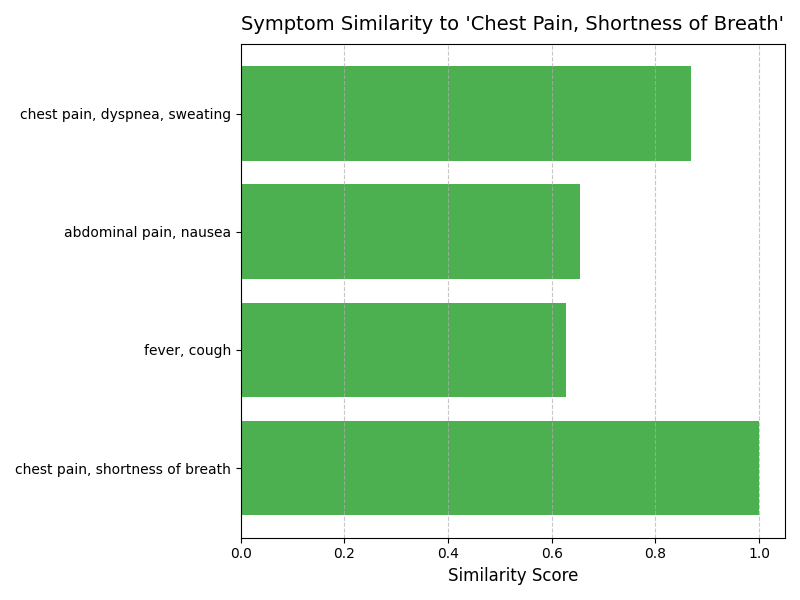

## Raw JSON Output (Debug)

{
  "diagnoses": [
    {
      "condition": "Myocardial Infarction",
      "confidence": 0.7
    },
    {
      "condition": "Pulmonary Embolism",
      "confidence": 0.6
    }
  ],
  "recommended_actions": [
    "Order ECG",
    "Order Troponin test",
    "Consider CT pulmonary angiography"
  ],
  "retrieved_context": [
    "Chest pain and shortness of breath may indicate myocardial infarction. Order ECG and troponin test.",
    "Pulmonary embolism presents with sudden dyspnea and chest pain. Consider CT pulmonary angiography."
  ],
  "patient_id": "patient-001",
  "triage_priority": "Emergent",
  "cardiovascular_risk": {
    "risk_score": 0,
    "risk_level": "Low"
  },
  "timestamp": "2025-04-18T19:03:51.194597"
}


In [14]:
# Example usage
patient_data = "35yo male, chest pain, shortness of breath, history of hypertension"
vitals = {"heart_rate": 110, "blood_pressure": "140/90"}
age = 35
patient_id = "patient-001"
language = "Spanish"  # Multi-language support

diagnosis, html_output = process_patient_data(patient_data, vitals, age, patient_id, language)

# Display results
display(HTML(html_output))

# For debugging, optionally display JSON
display(Markdown("## Raw JSON Output (Debug)"))
print(json.dumps(diagnosis, indent=2))